In [41]:
from duneanalytics import DuneAnalytics
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
from sklearn.model_selection import train_test_split
import tensorflow as tf
from datetime import datetime
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,7)})

import sys
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [53]:
df_btc_usd = yf.download("BTC-USD")
df_btc_usd.shape
df_btc_usd.reset_index('Date', inplace=True)
df_btc_usd['Date'] = pd.to_datetime(df_btc_usd['Date']).dt.date
df_btc_usd.dtypes
df_btc_usd.head()

[*********************100%***********************]  1 of 1 completed


(2919, 6)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


<AxesSubplot:>

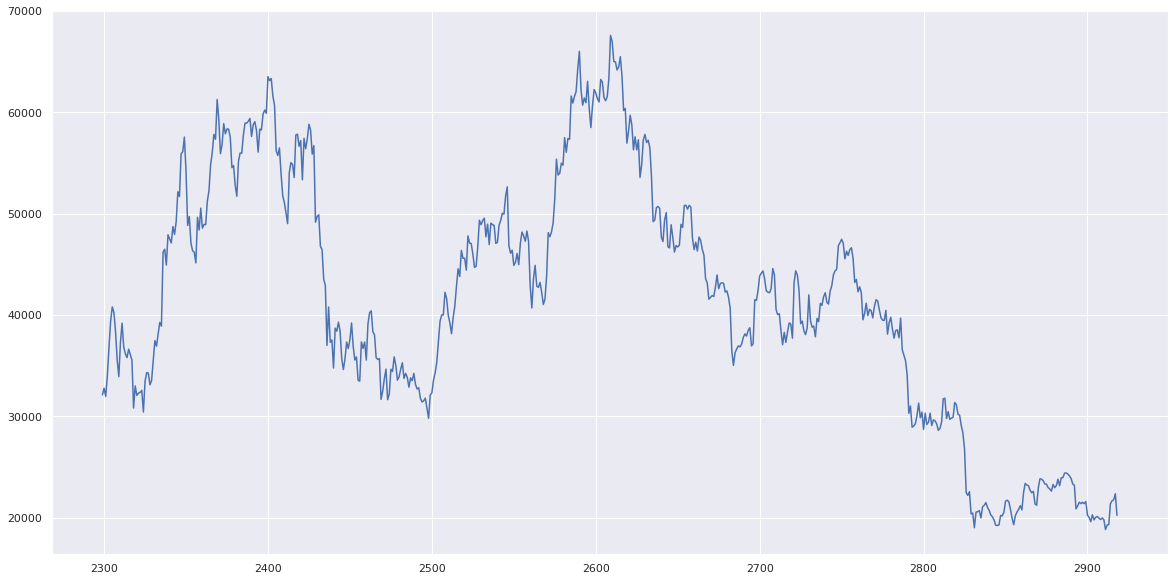

In [54]:
# let's omit portion of the graph where data fluctuate a lot
df_btc_usd = df_btc_usd.loc[pd.to_datetime(df_btc_usd['Date']) > datetime.strptime('2021-01-01', '%Y-%m-%d')]
df_btc_usd['Close'].plot(figsize=(20, 10))

In [61]:
f = Forecaster(y=df_btc_usd['Close'], current_dates=df_btc_usd['Date'], freq='D')
f

Forecaster(
    DateStartActuals=2021-01-02T00:00:00.000000000
    DateEndActuals=2022-09-14T00:00:00.000000000
    Freq=D
    N_actuals=620
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [62]:
f.generate_future_dates(12)
f.set_test_length(.2)
f.set_estimator('arima')
f.manual_forecast(call_me='arima1')

ValueError: The given frequency argument could not be matched to the given index.

ValueError: models argument with determine_best_by=None returns no evaluated forecasts

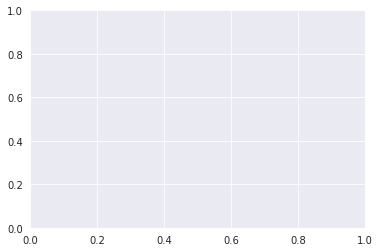

In [18]:
f.plot_test_set(ci=True)
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

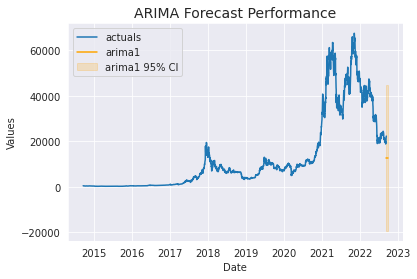

In [47]:
f.plot(ci=True)
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

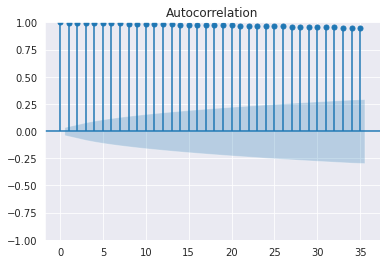

In [48]:
f.plot_acf()
plt.show()

2022-09-12 20:40:31,052 : WARNING : _showwarnmsg : /home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(



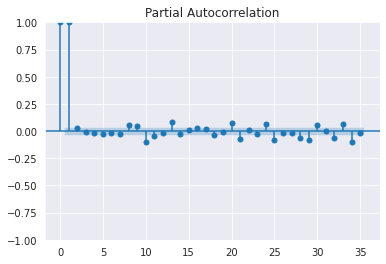

In [49]:
f.plot_pacf()
plt.show()

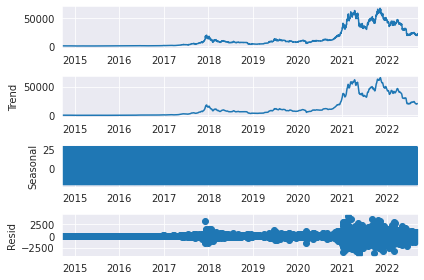

In [50]:
f.seasonal_decompose().plot()
plt.show()

In [51]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat)
print(pval)

-1.6321123714194283
0.46638520804907335


In [52]:
f.manual_forecast(order=(1,1,1),seasonal_order=(2,1,1,12),call_me='arima2')


2022-09-12 20:41:35,224 : WARNING : _showwarnmsg : /home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



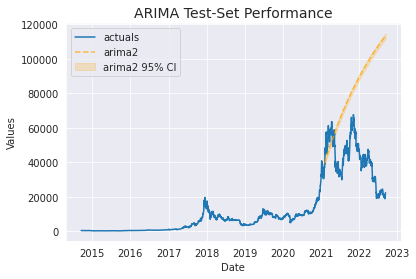

In [53]:
f.plot_test_set(ci=True,models='arima2')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

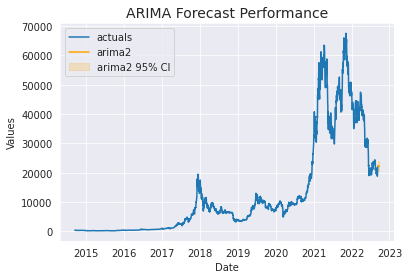

In [54]:
f.plot(ci=True,models='arima2')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [55]:
f.regr.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                 2918
Model:             ARIMA(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood              -23572.905
Date:                          Mon, 12 Sep 2022   AIC                          47157.810
Time:                                  20:42:34   BIC                          47193.656
Sample:                                       0   HQIC                         47170.725
                                         - 2918                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9998      1.900     -0.526      0.599      -4.725       2.725
ma.L1          0.9998      1.819      0.550      0.583      -2.565       4.565
ar.S.L12      -0.0660      0.008     -7.980      0.000      -0.082      -0.050
ar.S.L24       0.0648      0.008      8.266      0.000       0.049       0.080
ma.S.L12      -1.0000      0.082    -12.147      0.000      -1.161      -0.839
sigma2      6.504e+05   2.98e-06   2.18e+11      0.000     6.5e+05     6.5e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.01   Jarque-Bera (JB):             30651.99
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):            3492.35   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.29e+27. Standard errors may be unstable.
"""

In [56]:
auto_arima(
    f,
    start_P=1,
    start_q=1,
    max_p=6,
    max_q=6,
    m=12,
    seasonal=True,
    max_P=2,
    max_D=2,
    max_Q=2,
    max_d=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic",
    alpha=0.05,
    scoring='mse',
    call_me='arima3',
)

Performing stepwise search to minimize aic
 ARIMA(2,2,1)(1,0,1)[12]             : AIC=inf, Time=1.71 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=35762.363, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=35238.007, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=35238.088, Time=0.03 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=35228.444, Time=0.48 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=35217.806, Time=1.50 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=35238.282, Time=0.38 sec
 ARIMA(1,2,0)(2,0,2)[12]             : AIC=35219.774, Time=2.52 sec
 ARIMA(1,2,0)(1,0,2)[12]             : AIC=35218.358, Time=1.99 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=35735.312, Time=1.00 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=34980.312, Time=1.90 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=35009.686, Time=0.45 sec
 ARIMA(2,2,0)(2,0,0)[12]             : AIC=34997.241, Time=0.53 sec
 ARIMA(2,2,0)(2,0

2022-09-12 20:47:41,052 : WARNING : _showwarnmsg : /home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



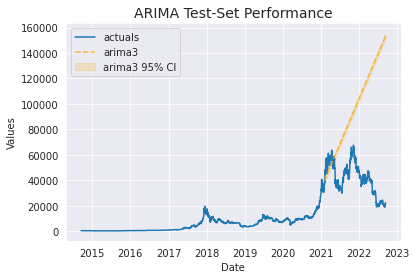

In [57]:
f.plot_test_set(ci=True,models='arima3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

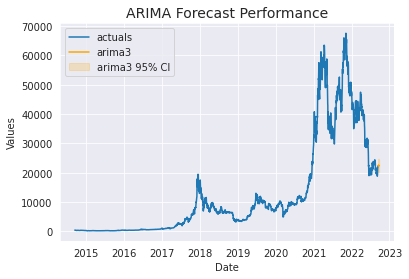

In [58]:
f.plot(ci=True,models='arima3')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [59]:
f.regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2918
Model:             ARIMA(6, 2, 2)x(2, 0, [], 12)   Log Likelihood              -23631.086
Date:                           Mon, 12 Sep 2022   AIC                          47284.171
Time:                                   20:48:49   BIC                          47349.929
Sample:                                        0   HQIC                         47307.858
                                          - 2918                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0206      1.642     -0.622      0.534      -4.238       2.197
ar.L2         -0.0166      0.036     -0.463      0.643      -0.087       0.054
ar.L3          0.0262      0.015      1.778      0.075      -0.003       0.055
ar.L4          0.0479      0.039      1.232      0.218      -0.028       0.124
ar.L5          0.0441      0.043      1.019      0.308      -0.041       0.129
ar.L6          0.0185      0.030      0.608      0.543      -0.041       0.078
ma.L1      -2.793e-05      1.648   -1.7e-05      1.000      -3.229       3.229
ma.L2         -1.0000      1.641     -0.609      0.542      -4.217       2.217
ar.S.L12      -0.0613      0.008     -7.496      0.000      -0.077      -0.045
ar.S.L24       0.0645      0.008      8.226      0.000       0.049       0.080
sigma2      6.389e+05   3.03e-08   2.11e+13      0.000    6.39e+05    6.39e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             31265.97
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):            4147.96   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.29e+28. Standard errors may be unstable.
"""